In [1]:
import dash
from dash import dash_table
from dash import html
from dash import dcc
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
import matplotlib.dates as mdates
import GraphHelpers as GH
from bisect import bisect_left, bisect_right
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import copy
%matplotlib inline

## General components

In [2]:
# Data extracted from CropData.cs InitialiseCropData() method

CropCoefficients = pd.read_excel('C:\\GitHubRepos\\Overseer-testing\\CropCoefficients\\CropCoefficients.xlsx')
CropCoefficients.set_index(['CropName'],inplace=True)
Categories = CropCoefficients.Category.drop_duplicates().values
CatFilt = (CropCoefficients.loc[:,'Category'] != 'Undefined') & (CropCoefficients.loc[:,'Category'] != 'Pasture')
CropCoefficients = CropCoefficients.loc[CatFilt,:]
CropDropDown = [{'label':i,'value':i} for i in CropCoefficients.index]

LincolnMet = pd.read_csv('C:\GitHubRepos\Weather\Broadfields\LincolnClean.met',delimiter = '\t')
LincolnMet.name = 'Lincoln'
GoreMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\GoreClean.met',delimiter = '\t')
GoreMet.name = 'Gore'
WhatatuMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\WhatatuClean.met',delimiter = '\t')
WhatatuMet.name = 'Napier'
PukekoheMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\PukekoheClean.met',delimiter = '\t')
PukekoheMet.name = 'Pukekohe'

metFiles ={'Pukekohe':PukekoheMet,'Whatatu':WhatatuMet,'Lincoln':LincolnMet,'Gore':GoreMet}

def tt(x,b):
    return max(0,x-b)

for f in metFiles.keys():
    metFiles[f].loc[:,'Date'] = pd.to_datetime(metFiles[f].loc[:,'Date'])
    metFiles[f].loc[:,'tt'] = [tt(x,5) for x in metFiles[f].Temp]
    
    metFiles[f].set_index('Date',inplace=True)

    CropCoefficientsMetDropDown = [{'label':i,'value':i} for i in metFiles.keys()]

Units = pd.DataFrame(index = ['t/ha','kg/ha'],data=[1000,1],columns=['toKG/ha'])
UnitsDropDown = [{'label':i,'value':i} for i in Units.index]

ResidueTreatments = pd.DataFrame(index = ['Incorporated','Left on Surface','Baled','Garzed','Burnt'],
                                 data = [0,0,80,50,90],
                                 columns = ['%returned'])
ResidueTreatmentsDropdown = [{'label':i,'value':i} for i in ResidueTreatments.index]

## Core crop model components

0.9926084586557181


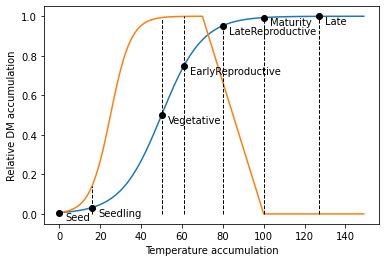

In [3]:
BiomassScaller = []
Covers = []
Xo_Biomass = 50
b_Biomass = Xo_Biomass*0.2
A_cov = 1
T_mat = Xo_Biomass*2
T_sen = T_mat-30
Xo_cov = T_mat * 0.25
b_cov = Xo_cov * 0.2
Tts = range(150)
for tt in Tts:
    BiomassScaller.append(1/(1+np.exp(-((tt-Xo_Biomass)/(b_Biomass)))))
    cover = 0
    if tt < T_sen:
        cover = A_cov * 1/(1+np.exp(-((tt-Xo_cov)/b_cov)))
    else:
        if tt < T_mat:
            cover = A_cov * (1-(tt-T_sen)/(T_mat-T_sen))
    Covers.append(cover)
DMscaller = pd.DataFrame(index=Tts,data=BiomassScaller,columns=['scaller'])
DMscaller.loc[:,'cover'] = Covers
print(DMscaller.loc[99,'scaller'])
plt.plot(DMscaller.loc[:,'scaller'])
plt.plot(DMscaller.loc[:,'cover'])
DMscaller.loc[:,'max'] = DMscaller.max(axis=1)

Methods = ['Seed','Seedling','Vegetative','EarlyReproductive','LateReproductive','Maturity','Late']
PrpnMaxDM = [0.0066,0.03,0.5,0.75,0.95,0.9933,0.9995]
StagePropns = pd.DataFrame(index = Methods, data = PrpnMaxDM,columns=['PrpnMaxDM']) 
for p in StagePropns.index:
    TTatProp = bisect_left(DMscaller.scaller,StagePropns.loc[p,'PrpnMaxDM'])
    StagePropns.loc[p,'PrpnTt'] = TTatProp/T_mat
    plt.plot(StagePropns.loc[p,'PrpnTt']*T_mat,StagePropns.loc[p,'PrpnMaxDM'],'o',color='k')
    plt.text(StagePropns.loc[p,'PrpnTt']*T_mat+3,StagePropns.loc[p,'PrpnMaxDM'],p,verticalalignment='top')
    plt.plot([StagePropns.loc[p,'PrpnTt']*T_mat]*2,[0,DMscaller.loc[round(StagePropns.loc[p,'PrpnTt'] * T_mat),'max']],'--',color='k',lw=1)
plt.ylabel('Relative DM accumulation')
plt.xlabel('Temperature accumulation')
EstablishStageDropdown = [{'label':i,'value':i} for i in Methods[:2]]
HarvestStageDropdown = [{'label':i,'value':i} for i in Methods[2:]]

## Model Functions

In [4]:
def CalculateMedianTt():
    ## Calculate median thermaltime for location
    duration = (FollowingConfig["HarvestDate"]-PriorConfig["EstablishDate"]).days + 7
    Met = metFiles[Location]
    FirstYear = int(Met.Year[0])
    years = [x for x in Met.Year.drop_duplicates().values[1:-1]]
    day = PriorConfig["EstablishDate"].day
    month = PriorConfig["EstablishDate"].month
    FirstDate = dt.date(FirstYear,month,day)
    TT = pd.DataFrame(columns = years,index = range(1,duration+1))
    for y in years:
        start = str(PriorConfig["EstablishDate"].day) + '-' + str(PriorConfig["EstablishDate"].month) + '-' + str(int(y))
        try:
            TT.loc[:,y] = Met.loc[start:,'tt'].cumsum().values[:duration]
        except:
            do = 'nothing'
    TTmed = (TT.median(axis=1))/30 # (TT.median(axis=1)-[5*x for x in TT.index])/30
    TTmed.index = pd.date_range(start=PriorConfig["EstablishDate"],periods=duration,freq='D',name='Date')
    TTmed.name = 'Tt'
    return TTmed

def CalculateCropUptake():
    for c in [PriorConfig,CurrentConfig,FollowingConfig]:
        ## Calculate model parameters 
        EstablishDate = c["EstablishDate"]
        HarvestDate = c["HarvestDate"]
        Crop = c["Crop"] 
        CropTt = Tt[EstablishDate:HarvestDate] - Tt[EstablishDate] 
        Tt_Harv = Tt[HarvestDate] - Tt[EstablishDate] 
        Tt_estab = Tt_Harv * (StagePropns.loc[c["EstablishStage"],'PrpnTt']/StagePropns.loc[c["HarvestStage"],'PrpnTt'])
        Xo_Biomass = (Tt_Harv + Tt_estab) *.5 * (1/StagePropns.loc[c["HarvestStage"],'PrpnTt'])
        b_Biomass = Xo_Biomass * .2
        # Calculate fitted patterns
        BiomassScaller = []
        for tt in CropTt:
            BiomassScaller.append(1/(1+np.exp(-((tt-Xo_Biomass)/(b_Biomass)))))
        UnitConverter = Units.loc[c["Units"],'toKG/ha']
        FreshProductWt = c["SaleableYield"] * (1 + c["FieldLoss"]/100) * (1 + c["DressingLoss"]/100)
        DryProductWt = FreshProductWt * UnitConverter * (1-c["MoistureContent"]/100)
        HI = CropCoefficients.loc[Crop,'a_Harvest'] + c["SaleableYield"] * UnitConverter * CropCoefficients.loc[Crop,'b_harvest']
        DryStoverWt = DryProductWt * 1/HI - DryProductWt 
        DryRootWt = (DryStoverWt+DryProductWt) * CropCoefficients.loc[Crop,'p_Root']
        TotalProductN = DryProductWt * CropCoefficients.loc[Crop,'Nconc_Tops']/100
        c['StoverN'] = DryStoverWt * CropCoefficients.loc[Crop,'Nconc_Stover']/100
        c['RootN'] = DryRootWt * CropCoefficients.loc[Crop,'Nconc_Roots']/100
        c['FieldLossN'] = (TotalProductN * c["FieldLoss"]/100)
        c['CropN'] = c['RootN'] + c['StoverN'] + TotalProductN
        dates = Tt[EstablishDate:HarvestDate].index
        CropN.loc[[('Root',d) for d in Tt[dates].index],'Values'] = np.multiply(np.multiply(BiomassScaller , 1/(StagePropns.loc[c["HarvestStage"],'PrpnMaxDM'])), c['RootN'])
        CropN.loc[[('Stover',d) for d in Tt[dates].index],'Values'] = np.multiply(np.multiply(BiomassScaller , 1/(StagePropns.loc[c["HarvestStage"],'PrpnMaxDM'])), c['RootN']+c['StoverN'])
        CropN.loc[[('FieldLoss',d) for d in Tt[dates].index],'Values'] = np.multiply(np.multiply(BiomassScaller , 1/(StagePropns.loc[c["HarvestStage"],'PrpnMaxDM'])), c['RootN'] + c['StoverN'] + c['FieldLossN'])
        CropN.loc[[('TotalCrop',d) for d in Tt[dates].index],'Values'] = np.multiply(np.multiply(BiomassScaller , 1/(StagePropns.loc[c["HarvestStage"],'PrpnMaxDM'])), c['CropN'])

def CalculateResidueMineralisation():
    p = 0.1
    for d in Tt.index[1:]:
        yesterday = d-dt.timedelta(days=1) 
        ResidualN.loc[('Root',d),'Values'] = ResidualN.loc[('Root',yesterday),'Values']
        ResidualN.loc[('Stover',d),'Values'] = ResidualN.loc[('Stover',yesterday),'Values']
        ResidualN.loc[('FieldLoss',d),'Values'] = ResidualN.loc[('FieldLoss',yesterday),'Values']
        DeltaRootN[d] = ResidualN.loc[('Root',d),'Values'] * (Tt[d] - Tt[yesterday])* p
        DeltaStoverN[d] = ResidualN.loc[('Stover',d),'Values'] * (Tt[d] - Tt[yesterday])* p
        DeltaFieldLossN[d] = ResidualN.loc[('FieldLoss',d),'Values'] * (Tt[d] - Tt[yesterday])* p
        DeltaResidueN[d] = DeltaRootN[d] + DeltaStoverN[d] + DeltaFieldLossN[d]
        ResidualN.loc[('Root',d),'Values'] -= DeltaRootN[d]
        ResidualN.loc[('Stover',d),'Values'] -= DeltaStoverN[d]
        ResidualN.loc[('FieldLoss',d),'Values'] -= DeltaFieldLossN[d]
        for c in [PriorConfig,CurrentConfig,FollowingConfig]:
            if d == (c["HarvestDate"] + dt.timedelta(days=7)):
                ResidualN.loc[('Root',d),'Values'] += c['RootN']
                ResidualN.loc[('Stover',d),'Values'] += c['StoverN']
                ResidualN.loc[('FieldLoss',d),'Values'] += c['FieldLossN']
    ResidualN.loc['Stover','Values'] = (ResidualN.loc['Root','Values'] + ResidualN.loc['Stover','Values']).values
    ResidualN.loc['FieldLoss','Values'] = (ResidualN.loc['Stover','Values'] + ResidualN.loc['FieldLoss','Values']).values

def CalculateSOMMineralisation():
    p = 0.1
    for d in Tt.index[1:]:
        yesterday = d - dt.timedelta(days=1)
        DeltaSOMN[d] =  FieldConfig['HWEON'] * (Tt[d] - Tt[yesterday])* p
    CurrentConfig["SOMN"] = DeltaSOMN[CurrentConfig["EstablishDate"]:CurrentConfig["HarvestDate"]].sum()
    
def CalculateSoilMineralN():
    FinalN = 30
    Eff = 0.8
    splits = 3
    duration = (CurrentConfig['HarvestDate']-CurrentConfig['EstablishDate']).days
    InCropMineralisation = CurrentConfig[['RootN',"StoverN","FieldLossN","SOMN"]].sum()
    NFertReq = (CurrentConfig["CropN"] + FinalN) - FieldConfig["MineralN"] - InCropMineralisation
    NFertReq = NFertReq * 1/Eff
    NFertReq = np.ceil(NFertReq)
    print(NFertReq)
    NAppn = NFertReq/splits
    plength = duration/(splits + 1)
    xlocs = [0]
    plength = np.ceil(duration/(splits + 1))
    xlocs = []
    for x in range(1,int(splits+1)):
        xlocs.append(x * plength)
    FertApplied = 0
    FertAppNo = 0
    maxSoilN = max(FieldConfig["MineralN"],FinalN + NAppn)
    SoilN[CurrentConfig['EstablishDate']] = FieldConfig["MineralN"]
    for d in SoilN[CurrentConfig['EstablishDate']:].index[1:]:
        yesterday = d - dt.timedelta(days=1)
        CropNd = np.nan_to_num(CropN.loc['TotalCrop','Values'].diff()[d],0)
        SoilN[d] = SoilN[yesterday] + DeltaResidueN[d] + DeltaSOMN[d] - CropNd 
        if (SoilN[yesterday] > SoilN[d]) and (SoilN[d] < FinalN) and (FertApplied < NFertReq): #and ((CropPatterns.iloc[d-1,4]-CropPatterns.iloc[d,4])<0):
            SoilN[d] += NAppn * Eff
            FertApplied += NAppn

## Declair Global properties

In [5]:
CropConfigs = ["Crop","SaleableYield","Units","FieldLoss","DressingLoss","MoistureContent",
               "EstablishDate","EstablishStage","HarvestDate","HarvestStage","ResidueTreatment",
               "RootN","StoverN","FieldLossN","CropN","SOMN"]

def setCropConfigDefaults(data):
     return pd.Series(index = CropConfigs,data = data)
                                 
PriorConfig = setCropConfigDefaults(["Wheatautumn",16000,"kg/ha",5,0,0,dt.datetime.strptime('01-04-2020','%d-%m-%Y'),
                                     "Seed",dt.datetime.strptime('1-10-2020','%d-%m-%Y'),"EarlyReproductive",
                                     "Incorporated",0,0,0,0,0])
CurrentConfig = setCropConfigDefaults(["Potatolong",70,"t/ha",10,5,77,dt.datetime.strptime('15-10-2020','%d-%m-%Y'),
                                       "Seed",dt.datetime.strptime('10-3-2021','%d-%m-%Y'),"Maturity",
                                       "Incorporated",0,0,0,0,0])
FollowingConfig = setCropConfigDefaults(["Wheatautumn",12,"t/ha",5,5,15,dt.datetime.strptime('15-06-2021','%d-%m-%Y'),
                                         "Seed",dt.datetime.strptime('10-2-2022','%d-%m-%Y'),"Maturity",
                                         "Incorporated",0,0,0,0,0])
FieldConfig = pd.Series(index = ['Location','HWEON','MineralN'],data=['Lincoln',17,19])

Location = 'Lincoln'
GraphStart = PriorConfig["HarvestDate"] - dt.timedelta(days=14)
EndYearDate = CurrentConfig["EstablishDate"] + dt.timedelta(days=356)
Tt = CalculateMedianTt()
DeltaRootN = pd.Series(index=Tt.index,data=[0.0]*Tt.index.size)
DeltaStoverN = pd.Series(index=Tt.index,data=[0.0]*Tt.index.size)
DeltaFieldLossN = pd.Series(index=Tt.index,data=[0.0]*Tt.index.size)
DeltaResidueN = pd.Series(index=Tt.index,data=[0.0]*Tt.index.size)
DeltaSOMN = pd.Series(index = Tt.index, data=[0.0]*Tt.index.size)
CropN = pd.DataFrame(index = pd.MultiIndex.from_product([['Root','Stover','FieldLoss','TotalCrop'],Tt.index],
                                                        names=['Component','Date']),columns=['Values'])
ResidualN = pd.DataFrame(index = pd.MultiIndex.from_product([['Root','Stover','FieldLoss'],Tt.index],names=['Component','Date']),
                             columns=['Values'],data = [0.0]*Tt.index.size*3)
SoilN = pd.Series(index = Tt.index, data=[np.nan]*Tt.index.size)


## Graph constructors

In [6]:
def ResizeDataFrames(Location,PriorEstablishDate,PriorHarvestDate,CurrentEstablishDate,FollowingHarvestDate):
    FieldConfig['Location'] = Location
    PriorConfig['EstablishDate'] = dt.datetime.strptime(str(PriorEstablishDate).split('T')[0],'%Y-%m-%d') 
    PriorConfig['HarvestDate'] = dt.datetime.strptime(str(PriorHarvestDate).split('T')[0],'%Y-%m-%d') 
    CurrentConfig['EstablishDate'] = dt.datetime.strptime(str(CurrentEstablishDate).split('T')[0],'%Y-%m-%d') 
    FollowingConfig['HarvestDate'] = dt.datetime.strptime(str(FollowingHarvestDate).split('T')[0],'%Y-%m-%d') 
    GraphStart = PriorConfig['HarvestDate'] - dt.timedelta(days=14)
    EndYearDate = CurrentConfig['HarvestDate'] + dt.timedelta(days=356)
    CalculateMedianTt()
    DeltaRootN = pd.Series(index=Tt.index,data=[0.0]*Tt.index.size)
    DeltaStoverN = pd.Series(index=Tt.index,data=[0.0]*Tt.index.size)
    DeltaFieldLossN = pd.Series(index=Tt.index,data=[0.0]*Tt.index.size)
    DeltaSOMN = pd.Series(index = Tt.index, data=[0.0]*Tt.index.size)
    CropN = pd.DataFrame(index = pd.MultiIndex.from_product([['Root','Stover','FieldLoss','TotalCrop'],Tt.index],
                                                        names=['Component','Date']),columns=['Values'])
    ResidualN = pd.DataFrame(index = pd.MultiIndex.from_product([['Root','Stover','FieldLoss'],Tt.index],names=['Component','Date']),
                             columns=['Values'],data = [0.0]*Tt.index.size*3)
    
def CropGraph():
    LiveData = CropN.reset_index()
    ResidueData = ResidualN.reset_index()
    CropData = pd.concat([LiveData,ResidueData],keys=['Live','Residue'],names=['Status','ind']).reset_index()
    fig = px.line(data_frame=CropData,x='Date',y='Values',color='Component',color_discrete_sequence=['brown','orange','red','green'],
                  line_dash='Status', line_dash_sequence=['solid','dot'], range_x = [GraphStart,EndYearDate])
    fig.update_layout(title_text="Crop and Residue N", title_font_size = 30, title_x = 0.5, title_xanchor = 'center')
    fig.update_yaxes(title_text="Nitrogen (kg/ha)", title_font_size = 20)
    fig.update_xaxes(title_text=None)

    return fig

def MineralisationGraph():
    MineralisationData = pd.DataFrame(index=pd.MultiIndex.from_product([['SOM','Residue'],Tt[CurrentConfig['EstablishDate']:].index],
                                      names=['Component','Date']),columns=['Values'])
    MineralisationData.loc['SOM','Values'] = DeltaSOMN[CurrentConfig['EstablishDate']:].cumsum().values
    MineralisationData.loc['Residue','Values'] = (DeltaRootN[CurrentConfig['EstablishDate']:] + DeltaStoverN[CurrentConfig['EstablishDate']:] + DeltaFieldLossN[CurrentConfig['EstablishDate']:]).cumsum().values + MineralisationData.loc['SOM','Values'].values                                 
    MineralisationData.reset_index(inplace=True)
    fig = px.line(data_frame=MineralisationData,x='Date',y='Values',color='Component',color_discrete_sequence=['brown','green'],
                  range_x = [GraphStart,EndYearDate])
    fig.update_layout(title_text="N Mineralisation", title_font_size = 30, title_x = 0.5, title_xanchor = 'center')
    fig.update_yaxes(title_text="Nitrogen (kg/ha)", title_font_size = 20)
    fig.update_xaxes(title_text=None)
    return fig

def SoilNGraph():
    # fig = px.line(x=SoilN.index,y=SoilN.values,color_discrete_sequence=['brown'],
    #               range_x = [GraphStart,EndYearDate])
    df = pd.DataFrame(index=SoilN.index,data=SoilN.values,columns=['Values'])
    fig = df.iplot(asFigure=True, kind='line',
               #xTitle='Dates',yTitle='Returns',title='Returns',
               vspan={'x0':GraphStart,'x1':EndYearDate,'color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4})
    fig.update_layout(title_text="Soi Mineral N", title_font_size = 30, title_x = 0.5, title_xanchor = 'center')
    fig.update_yaxes(title_text="Nitrogen (kg/ha)", title_font_size = 20)
    fig.update_xaxes(title_text=None)
    # fig.add_annotation(dict(font=dict(color='black',size=15), x=.3,y=0.7,showarrow=False,
    #                                 text=np.int(FertN.sum()),
    #                                 textangle=0,
    #                                 xanchor='center',
    #                                 xref="paper",
    #                                 yref="paper"))
    x0 = [GraphStart, CurrentConfig["HarvestDate"]]
    x1 = [CurrentConfig["EstablishDate"], EndYearDate]
    # get dict from tuple made by vspan()
    xElem = fig['layout']['shapes'][0]
    # container (list) for dicts / shapes
    shp_lst=[]
    # make dicts according to x0 and X1
    # and edit elements of those dicts
    for i in range(0,len(x0)):
        shp_lst.append(copy.deepcopy(xElem))
        shp_lst[i]['x0'] = x0[i]
        shp_lst[i]['x1'] = x1[i]
        shp_lst[i]['line']['color'] = 'rgba(0,0,0,0)'
    # replace shape in fig with multiple new shapes
    fig['layout']['shapes']= tuple(shp_lst)
    fig.update_layout(xaxis_range=[GraphStart,EndYearDate])

    return fig

## Crop Configuration and status constructors

In [7]:
def CropInputs(pos):
    CropConfig = globals()[pos+"Config"]
    return dbc.CardBody([
    dbc.Row([dbc.Col([html.H1(pos+" Crop")], width=6 ,align='center'),
             dbc.Col([dcc.Dropdown(id=pos+"Crop",options = CropDropDown,value=CropConfig["Crop"])], width=6 ,align='center'),]),
    #html.Br(),
    dbc.Row([dbc.Col([html.Div('')], width=3, align='center'),
             dbc.Col([html.Div('Saleable Yield')], width=3, align='center'),
             dbc.Col([dcc.Input(id=pos+"SaleableYield", type="number",value=CropConfig["SaleableYield"],min=0.01)], width=3, align='center'),
             dbc.Col([dcc.Dropdown(id=pos+"Units", options = UnitsDropDown,value=CropConfig["Units"])], width=3, align='center')]), 
    # html.Br(),
    dbc.Row([dbc.Col([html.Div('')], width=3, align='center'),
             dbc.Col([html.Div('Field Loss (%)')], width=3, align='center'),
             dbc.Col([html.Div('Dressing loss (%)')], width=3, align='center'),
             dbc.Col([html.Div('Moisture (%)')], width=3, align='center')]), 
    # html.Br(),
    dbc.Row([dbc.Col([html.Div('')], width=3, align='center'),
             dbc.Col([dcc.Input(id=pos+"FieldLoss", type="number",value=CropConfig["FieldLoss"],min=0,max=100)], width=3, align='center'),
             dbc.Col([dcc.Input(id=pos+"DressingLoss", type="number",value=CropConfig["DressingLoss"],min=0,max=100)], width=3, align='center'),
             dbc.Col([dcc.Input(id=pos+"MoistureContent", type="number",value=CropConfig["MoistureContent"],min=0,max=96)], width=3, align='center')]), 
    # html.Br(),
    dbc.Row([dbc.Col([html.Div('Planting Date')], width=3, align='center'),
             dbc.Col([dcc.DatePickerSingle(id=pos+"EstablishDate", min_date_allowed=dt.date(2020, 1, 1),
                                            max_date_allowed=dt.date(2022, 12, 31), initial_visible_month=dt.date(2021, 5, 15),
                                            date=CropConfig["EstablishDate"],display_format='D-MMM-YYYY')], width=3, align='center'),
             dbc.Col([html.Div('Planting method')], width=3, align='center'),
             dbc.Col([dcc.Dropdown(id=pos+"EstablishStage",options =EstablishStageDropdown,value=CropConfig["EstablishStage"])], width=3, align='center')]), 
    # html.Br(),
    dbc.Row([dbc.Col([html.Div('Harvest Date')], width=3, align='center'),
             dbc.Col([dcc.DatePickerSingle(id=pos+"HarvestDate", min_date_allowed=dt.date(2020, 1, 1),
                                            max_date_allowed=dt.date(2022, 12, 31), initial_visible_month=dt.date(2021, 5, 15),
                                            date=CropConfig["HarvestDate"],display_format='D-MMM-YYYY')], width=3, align='center'), 
             dbc.Col([html.Div('Harvest Stage')], width=3, align='center'),
             dbc.Col([dcc.Dropdown(id=pos+"HarvestStage",options = HarvestStageDropdown,value=CropConfig["HarvestStage"])], width=3, align='center')]), 
    # html.Br(),
    dbc.Row([dbc.Col([html.Div('ResidueTreatment')], width=3, align='center'), 
            dbc.Col([dcc.Dropdown(id=pos+"ResidueTreatment", options=ResidueTreatmentsDropdown,value=CropConfig["ResidueTreatment"])],width=3, align='center')]), 
    ])

def CropState(pos):
    return dbc.CardBody([
    dbc.Row([dbc.Col([html.H1(pos+" Crop")], width=6 ,align='center'),
             dbc.Col(html.Div(id=pos+"Crop",children=""), width=6 ,align='center')]),
    html.Br(),
    dbc.Row([dbc.Col(html.Div(''), width=3, align='center'),
             dbc.Col(html.Div('Saleable Yield'), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"SaleableYield", children=""), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"Units",children=""), width=3, align='center')]), 
    html.Br(),
    dbc.Row([dbc.Col(html.Div(''), width=3, align='center'),
             dbc.Col(html.Div('Field Loss (%)'), width=3, align='center'),
             dbc.Col(html.Div('Dressing loss (%)'), width=3, align='center'),
             dbc.Col(html.Div('Moisture (%)'), width=3, align='center')]), 
    html.Br(),
    dbc.Row([dbc.Col(html.Div(''), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"FieldLoss", children=""), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"DressingLoss", children=""), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"MoistureContent", children=""), width=3, align='center')]), 
    html.Br(),
    dbc.Row([dbc.Col(html.Div('Planting Date'), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"EstablishDate", children=""), width=3, align='center'),
             dbc.Col(html.Div('Planting method'), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"EstablishStage",children=""), width=3, align='center')]), 
    html.Br(),
    dbc.Row([dbc.Col(html.Div('Harvest Date'), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"HarvestDate",children=""), width=3, align='center'), 
             dbc.Col(html.Div('Harvest Stage'), width=3, align='center'),
             dbc.Col(html.Div(id=pos+"HarvestStage",children=""), width=3, align='center')]), 
    html.Br(),
    dbc.Row([dbc.Col(html.Div('ResidueTreatment'), width=3, align='center'), 
             dbc.Col(html.Div(id=pos+"ResidueTreatment", children=""),width=3, align='center')]), 
    ])




## App layout and callbacks

In [8]:
app = JupyterDash(external_stylesheets=[dbc.themes.SLATE])

app.layout = html.Div([
    dbc.Row([dbc.Col(html.H1("Field Location"), width=2 ,align='center'),
             dbc.Col(dcc.Dropdown(id="Location",options = MetDropDown,value='Lincoln'), width=3 ,align='center')]),
    dbc.Row([dbc.Col(html.Button("Refresh",id="RefreshButton"),width=2,align='center'),
             dbc.Col(html.H1("Current Soil Tests"), width=2 ,align='center'),
             dbc.Col(html.Div('HWEON'),width=1,align='center'),
             dbc.Col(dcc.Input(id="HWEON",type="number",value = 17,min=0),width=1, align='center'),
             dbc.Col(html.Div(''),width=1, align='center'),
             dbc.Col(html.Div('Mineral N'),width=1,align='center'),
             dbc.Col(dcc.Input(id="MineralN",type="number",value = 17,min=0),width=1, align='center'),
             ]),
    dbc.Row([dbc.Col(dbc.Card(CropInputs("Prior"))),
             dbc.Col(dbc.Card(CropInputs("Current"))),
             dbc.Col(dbc.Card(CropInputs("Following")))]),
    html.Br(),
    dbc.Row([dbc.Col(dbc.Card(dcc.Graph(id='CropUptakeGraph')),width=4),
             dbc.Col(dbc.Card(dcc.Graph(id='SoilNGraph')),width=4),
             dbc.Col(dbc.Card(dcc.Graph(id='SoilMineralisationGraph')),width=4)]),
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),
    dbc.Row([dbc.Col(dbc.Card(CropState("StatePrior"))),
             dbc.Col(dbc.Card(CropState("StateCurrent"))),
             dbc.Col(dbc.Card(CropState("StateFollowing")))]),
    dbc.Row([dbc.Col(html.H1("Field Location"), width=2 ,align='center'),
             dbc.Col(html.Div(id="StateLocation",children =""), width=3 ,align='center')]),
    dbc.Row([dbc.Col(html.Div(""),width=2,align='center'),
             dbc.Col(html.H1("Current Soil Tests"), width=2 ,align='center'),
             dbc.Col(html.Div('HWEON'),width=1,align='center'),
             dbc.Col(html.Div(id="StateHWEON",children=""),width=1, align='center'),
             dbc.Col(html.Div(''),width=1, align='center'),
             dbc.Col(html.Div('Mineral N'),width=1,align='center'),
             dbc.Col(html.Div(id="StateMineralN",children=""),width=1, align='center'),
             ]),
    dbc.Row([dbc.Col(dbc.Card(dcc.Graph(id='TtGraph')),width=4)]) 
    ])

@app.callback(
    Output('TtGraph','figure'),
    Input('Location','value'),
    Input('PriorEstablishDate','date'),
    Input('PriorHarvestDate','date'),
    Input('CurrentEstablishDate','date'),
    Input('FollowingHarvestDate','date'),
    )
def update_Tt(Location,PriorEstablishDate,PriorHarvestDate,CurrentEstablishDate,FollowingHarvestDate):
    ResizeDataFrames(Location,PriorEstablishDate,PriorHarvestDate,CurrentEstablishDate,FollowingHarvestDate)
    CalculateMedianTt()
    CropN.loc[:,'Values'] = np.nan
    CalculateCropUptake()
    CalculateResidueMineralisation()
    CalculateSOMMineralisation()
    CalculateSoilMineralN()
    fig = px.line(x=Tt.index,y=Tt.values)
    return fig

@app.callback(Output("StateLocation",'children'),Input("Location",'value'))
def StateLocation(Location):
    FieldConfig["Location"] = Location
    return Location
@app.callback(Output("StateHWEON",'children'),Input("HWEON",'value'))
def StateLocation(HWEON):
    FieldConfig["HWEON"] = HWEON
    return HWEON
@app.callback(Output("StateMineralN",'children'),Input("MineralN",'value'))
def StateLocation(MineralN):
    FieldConfig["MineralN"] = MineralN
    return MineralN

@app.callback(Output("StatePriorCrop",'children'),Input("PriorCrop",'value'))
def StatePriorCrop(PriorCrop):
    PriorConfig["Crop"] = PriorCrop
    return PriorCrop
@app.callback(Output("StatePriorSaleableYield",'children'),Input("PriorSaleableYield",'value'))
def StatePriorCrop(PriorSaleableYield):
    PriorConfig["SaleableYield"] = PriorSaleableYield
    return PriorSaleableYield
@app.callback(Output("StatePriorUnits",'children'),Input("PriorUnits",'value'))
def StatePriorCrop(PriorUnits):
    PriorConfig["Units"] = PriorUnits
    return PriorUnits
@app.callback(Output("StatePriorFieldLoss",'children'),Input("PriorFieldLoss",'value'))
def StatePriorCrop(PriorFieldLoss):
    PriorConfig["FieldLoss"] = PriorFieldLoss
    return PriorFieldLoss
@app.callback(Output("StatePriorDressingLoss",'children'),Input("PriorDressingLoss",'value'))
def StatePriorCrop(PriorDressingLoss):
    PriorConfig["DressingLoss"] = PriorDressingLoss
    return PriorDressingLoss
@app.callback(Output("StatePriorMoistureContent",'children'),Input("PriorMoistureContent",'value'))
def StatePriorCrop(PriorMoistureContent):
    PriorConfig["MoistureContent"] = PriorMoistureContent
    return PriorMoistureContent
@app.callback(Output("StatePriorEstablishDate",'children'),Input("PriorEstablishDate",'date'))
def StatePriorCrop(PriorEstablishDate):
    PriorConfig["EstablishDate"] = dt.datetime.strptime(str(PriorEstablishDate).split('T')[0],'%Y-%m-%d')
    return PriorEstablishDate
@app.callback(Output("StatePriorHarvestDate",'children'),Input("PriorHarvestDate",'date'))
def StatePriorCrop(PriorHarvestDate):
    PriorConfig["HarvestDate"] = dt.datetime.strptime(str(PriorHarvestDate).split('T')[0],'%Y-%m-%d')
    return PriorHarvestDate
@app.callback(Output("StatePriorEstablishStage",'children'),Input("PriorEstablishStage",'value'))
def StateCurrentCrop(PriorEstablishStage):
    PriorConfig["EstablishStage"] = PriorEstablishStage
    return PriorEstablishStage
@app.callback(Output("StatePriorHarvestStage",'children'),Input("PriorHarvestStage",'value'))
def StatePriorCrop(PriorHarvestStage):
    PriorConfig["HarvestStage"] = PriorHarvestStage
    return PriorHarvestStage
@app.callback(Output("StatePriorResidueTreatment",'children'),Input("PriorResidueTreatment",'value'))
def StatePriorCrop(PriorResidueTreatment):
    PriorConfig["ResidueTreatment"] = PriorResidueTreatment
    return PriorResidueTreatment

@app.callback(Output("StateCurrentCrop",'children'),Input("CurrentCrop",'value'))
def StateCurrentCrop(CurrentCrop):
    CurrentConfig["Crop"] = CurrentCrop
    return CurrentCrop
@app.callback(Output("StateCurrentSaleableYield",'children'),Input("CurrentSaleableYield",'value'))
def StateCurrentCrop(CurrentSaleableYield):
    CurrentConfig["SaleableYield"] = CurrentSaleableYield
    return CurrentSaleableYield
@app.callback(Output("StateCurrentUnits",'children'),Input("CurrentUnits",'value'))
def StateCurrentCrop(CurrentUnits):
    CurrentConfig["Units"] = CurrentUnits
    return CurrentUnits
@app.callback(Output("StateCurrentFieldLoss",'children'),Input("CurrentFieldLoss",'value'))
def StateCurrentCrop(CurrentFieldLoss):
    CurrentConfig["FieldLoss"] = CurrentFieldLoss
    return CurrentFieldLoss
@app.callback(Output("StateCurrentDressingLoss",'children'),Input("CurrentDressingLoss",'value'))
def StateCurrentCrop(CurrentDressingLoss):
    CurrentConfig["DressingLoss"] = CurrentDressingLoss
    return CurrentDressingLoss
@app.callback(Output("StateCurrentMoistureContent",'children'),Input("CurrentMoistureContent",'value'))
def StateCurrentCrop(CurrentMoistureContent):
    CurrentConfig["MoistureContent"] = CurrentMoistureContent
    return CurrentMoistureContent
@app.callback(Output("StateCurrentEstablishDate",'children'),Input("CurrentEstablishDate",'date'))
def StateCurrentCrop(CurrentEstablishDate):
    CurrentConfig["EstablishDate"] = dt.datetime.strptime(str(CurrentEstablishDate).split('T')[0],'%Y-%m-%d')
    return CurrentEstablishDate
@app.callback(Output("StateCurrentHarvestDate",'children'),Input("CurrentHarvestDate",'date'))
def StateCurrentCrop(CurrentHarvestDate):
    CurrentConfig["HarvestDate"] = dt.datetime.strptime(str(CurrentHarvestDate).split('T')[0],'%Y-%m-%d')
    return CurrentHarvestDate
@app.callback(Output("StateCurrentEstablishStage",'children'),Input("CurrentEstablishStage",'value'))
def StateCurrentCrop(CurrentEstablishStage):
    CurrentConfig["EstablishStage"] = CurrentEstablishStage
    return CurrentEstablishStage
@app.callback(Output("StateCurrentHarvestStage",'children'),Input("CurrentHarvestStage",'value'))
def StateCurrentCrop(CurrentHarvestStage):
    CurrentConfig["HarvestStage"] = CurrentHarvestStage
    return CurrentHarvestStage
@app.callback(Output("StateCurrentResidueTreatment",'children'),Input("CurrentResidueTreatment",'value'))
def StateCurrentCrop(CurrentResidueTreatment):
    CurrentConfig["ResidueTreatment"] = CurrentResidueTreatment
    return CurrentResidueTreatment

@app.callback(Output("StateFollowingCrop",'children'),Input("FollowingCrop",'value'))
def StateFollowingCrop(FollowingCrop):
    FollowingConfig["Crop"] = FollowingCrop
    return FollowingCrop
@app.callback(Output("StateFollowingSaleableYield",'children'),Input("FollowingSaleableYield",'value'))
def StateFollowingCrop(FollowingSaleableYield):
    FollowingConfig["SaleableYield"] = FollowingSaleableYield
    return FollowingSaleableYield
@app.callback(Output("StateFollowingUnits",'children'),Input("FollowingUnits",'value'))
def StateFollowingCrop(FollowingUnits):
    FollowingConfig["Units"] = FollowingUnits
    return FollowingUnits
@app.callback(Output("StateFollowingFieldLoss",'children'),Input("FollowingFieldLoss",'value'))
def StateFollowingCrop(FollowingFieldLoss):
    FollowingConfig["FieldLoss"] = FollowingFieldLoss
    return FollowingFieldLoss
@app.callback(Output("StateFollowingDressingLoss",'children'),Input("FollowingDressingLoss",'value'))
def StateFollowingCrop(FollowingDressingLoss):
    FollowingConfig["DressingLoss"] = FollowingDressingLoss
    return FollowingDressingLoss
@app.callback(Output("StateFollowingMoistureContent",'children'),Input("FollowingMoistureContent",'value'))
def StateFollowingCrop(FollowingMoistureContent):
    FollowingConfig["MoistureContent"] = FollowingMoistureContent
    return FollowingMoistureContent
@app.callback(Output("StateFollowingEstablishDate",'children'),Input("FollowingEstablishDate",'date'))
def StateFollowingCrop(FollowingEstablishDate):
    FollowingConfig["EstablishDate"] = dt.datetime.strptime(str(FollowingEstablishDate).split('T')[0],'%Y-%m-%d')
    return FollowingEstablishDate
@app.callback(Output("StateFollowingHarvestDate",'children'),Input("FollowingHarvestDate",'date'))
def StateFollowingCrop(FollowingHarvestDate):
    FollowingConfig["HarvestDate"] = dt.datetime.strptime(str(FollowingHarvestDate).split('T')[0],'%Y-%m-%d')
    return FollowingHarvestDate
@app.callback(Output("StateFollowingEstablishStage",'children'),Input("FollowingEstablishStage",'value'))
def StateCurrentCrop(FollowingEstablishStage):
    FollowingConfig["EstablishStage"] = FollowingEstablishStage
    return FollowingEstablishStage
@app.callback(Output("StateFollowingHarvestStage",'children'),Input("FollowingHarvestStage",'value'))
def StateFollowingCrop(FollowingHarvestStage):
    FollowingConfig["HarvestStage"] = FollowingHarvestStage
    return FollowingHarvestStage
@app.callback(Output("StateFollowingResidueTreatment",'children'),Input("FollowingResidueTreatment",'value'))
def StateFollowingCrop(FollowingResidueTreatment):
    FollowingConfig["ResidueTreatment"] = FollowingResidueTreatment
    return FollowingResidueTreatment

@app.callback(
    Output('CropUptakeGraph','figure'),
    Output('SoilMineralisationGraph','figure'),
    Output('SoilNGraph','figure'),
    Input('RefreshButton','n_clicks'))
def RefreshGraphs(n_clicks):
    CalculateMedianTt()
    CropN.loc[:,'Values'] = np.nan
    CalculateCropUptake()
    CalculateResidueMineralisation()
    CalculateSOMMineralisation()
    CalculateSoilMineralN()
    return CropGraph(), MineralisationGraph(), SoilNGraph()

# Run app and display result inline in the notebook
app.run_server(mode='External')

Dash app running on http://127.0.0.1:8050/
